<a href="https://colab.research.google.com/github/peyman886/Deep_Learning_course/blob/main/HW2_practical_Q1%2C2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

======================================================
### **Student Information:**
* Name = Peyman
* Last Name = Naseri
* ID = 96100522

======================================================

# Importing

In [ ]:
#delete model folder
# import shutil
# path = './model'
# shutil.rmtree(path)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *


from tensorflow.keras.callbacks import TensorBoard
# Load the TensorBoard notebook extension (to be able to see it in the notebook).
%load_ext tensorboard
import datetime   # to organize TensorBoard files

tf.get_logger().setLevel('ERROR')

In [ ]:
'''
  https://research.google.com/colaboratory/local-runtimes.html
  
  for run code on local gpu:
    run this comand in anaconda prompet:
      1) pip install jupyter_http_over_ws
      2) jupyter serverextension enable --py jupyter_http_over_ws
      3) jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0

pip install jupyter_http_over_ws
jupyter serverextension enable --py jupyter_http_over_ws
jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0

    copy url and paste on colab

'''
#Check GPU

if len(tf.config.list_physical_devices('GPU')) > 0:
  !nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

name, driver_version, memory.total [MiB]
GeForce RTX 2080 with Max-Q Design, 460.89, 8192 MiB


# DATA

## Downloading datasets


In [ ]:
(X, y), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

## Show 

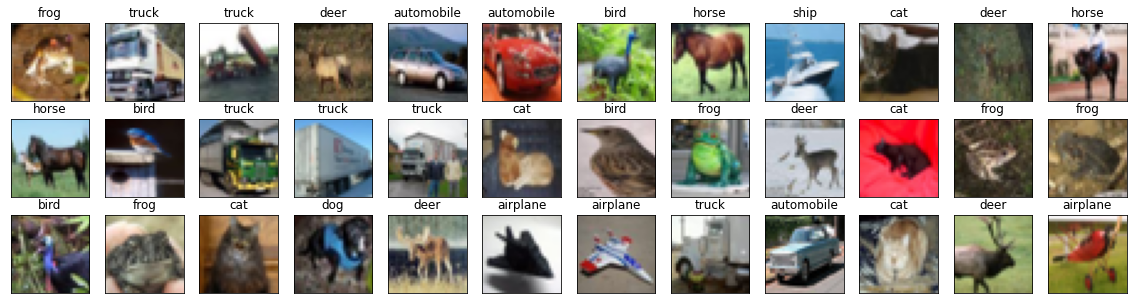

In [ ]:
## show a few sample of dataset
# the images are matrices itself, meaning we will use numpy to read them in and matplotlib to "plot" them. 

d = {
    0:'airplane',
    1:'automobile',
    2:'bird',
    3:'cat',
    4:'deer',
    5:'dog', 
    6:'frog',
    7:'horse',
    8:'ship', 
    9:'truck'
    }
def plot_images(X,y):
  fig = plt.figure(figsize=(20,5))
  for i in range(36):
    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X[i]))
    ax.set_title(d[y[i][0]])
plot_images(X=X, y=y)


## One Hot encoding

In [ ]:
num_classes = len(np.unique(y))
y = keras.utils.to_categorical(y, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

#change data type from int to float
X = X.astype('float32')
X_test = X_test.astype('float32')

## Split and Normalization

In [ ]:
#split orginal data into training and validation sets and normalizing them
from sklearn.model_selection import train_test_split 

X_test = keras.utils.normalize(X_test, axis=1)

def split_normal(X=X, y=y, data_name=''):
  X_train, X_valid, y_train, y_valid = train_test_split(
      X, y, test_size=0.2, random_state=43, shuffle=True)
  X_train = keras.utils.normalize(X_train, axis=1)
  X_valid = keras.utils.normalize(X_valid, axis=1)
  # X_train /= 255
  # X_valid /= 255
  # X_test /= 255
  print('shape X_train'+data_name,':', X_train.shape)
  print('shape X_valid'+data_name,':', X_valid.shape)
  print('shape X_test:', X_test.shape)
  print()
  print('shape y_train'+data_name,':', y_train.shape)
  print('shape y_valid'+data_name,':',y_valid.shape)
  print('shape y_test:', y_test.shape)
  return (X_train, X_valid, y_train, y_valid)

X_train, X_valid, y_train, y_valid = split_normal()

shape X_train : (40000, 32, 32, 3)
shape X_valid : (10000, 32, 32, 3)
shape X_test: (10000, 32, 32, 3)

shape y_train : (40000, 10)
shape y_valid : (10000, 10)
shape y_test: (10000, 10)


## decrese data

In [ ]:
# this func decrese size a class with ramoving
def decrese_size_class(X, y, class_id, scale_size):
    itemindex = np.where(y[:,class_id]==1)[0]
    np.random.shuffle(itemindex)
    remove_size = itemindex.size//scale_size
    remove_index = itemindex[:-remove_size]
    X_new = np.delete(X, remove_index, axis=0)
    y_new = np.delete(y, remove_index, axis=0)
    return(X_new, y_new) 

## increse data

In [ ]:
from keras.preprocessing.image import ImageDataGenerator 
datagen = ImageDataGenerator( rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, 
                         shear_range=0.2, zoom_range=0.2, horizontal_flip=True, 
                         fill_mode="nearest")
# this func increase size a class with data augmentation 
def increase_size_class(X, y, class_id, scale_size):
    X_new = X.copy()
    y_new = y.copy()
    itemindex = np.where(y[:,class_id]==1)[0]
    np.random.shuffle(itemindex)
    amount_increase_size = itemindex.size*scale_size-itemindex.size
    for i in range(10):
      imGen = datagen.flow(X[itemindex], y[itemindex], batch_size=amount_increase_size//10)
      X_new = np.concatenate((X_new, imGen[0][0]))
      y_new = np.concatenate((y_new, imGen[0][1]))
    return(X_new, y_new) 

# Network

## building MLP

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation

import time

#create a fully conected layer
def add_FC_layer(model, units, activation='relu',
                 has_batchNormalization=False, has_dropout=False, dropout_rate=0.2):
  model.add(Dense(units=units))
  if has_batchNormalization:
      model.add(BatchNormalization())
  model.add(Activation(activation))
  if has_dropout:
    model.add(Dropout(dropout_rate))
  return model

#create a MLP without input layer
def FC_net(model, num_layer=3, shape=(512, 256, 128), activation='relu',
           has_batchNormalization=False, has_dropout=False, dropout_rate=0.5):
  for i in range(num_layer):
    model = add_FC_layer(model=model,units=shape[i],
                         has_batchNormalization=has_batchNormalization,
                         has_dropout=has_dropout, dropout_rate=dropout_rate)
  model.add(Dense(num_classes, activation='softmax'))
  # model.summary()
  return model          

def build_MLP(name, activation='relu'):
  model = Sequential(name=name)
  model.add(Flatten(input_shape = X_train.shape[1:]))
  model = FC_net(model=model, activation=activation)
  return model

## building CNN

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras import regularizers
# create conv layer
def add_conv_layer(model, filters, kernel_size=3, strides=1, activation='relu', is_first_layer=False,
                   has_batchNormalization=False, has_pooling=False, has_dropout=False,dropout_rate=0.2):
  weight_decay = 1e-4
  if is_first_layer:
    model.add(Conv2D(filters=filters, kernel_size=kernel_size, strides=strides,
                     kernel_regularizer=regularizers.l2(weight_decay),
                     activation=activation,
                    padding='same', input_shape = X_train.shape[1:]))
  else:
    model.add(Conv2D(filters=filters, kernel_size=kernel_size,
                     kernel_regularizer=regularizers.l2(weight_decay),
                     activation=activation,
                     strides=strides, padding='same'))
  if has_batchNormalization:
    model.add(BatchNormalization())
  # model.add(Activation(activation))
  if has_pooling:
    model.add(MaxPooling2D(pool_size=2))
  if has_dropout:
    model.add(Dropout(dropout_rate))
  return model

def build_CNN(name,num_layer=6,shape=(32,32,64,64,128,128), activation='relu',
              has_batchNormalization=False, has_pooling=False,
              has_dropout=False, dropout_rate=0.2,
              global_avg=False):
  #CNN part:
  model = Sequential(name=name)
  model = add_conv_layer(model, filters=shape[0], is_first_layer=True,
                         has_batchNormalization=has_batchNormalization)
                        #  has_pooling=has_pooling)
  for i in range(1,num_layer):
    # use pooling in even layers
    if i%2==1:
      model = add_conv_layer(model=model,filters=shape[i],
                            has_batchNormalization=has_batchNormalization,
                            has_pooling=has_pooling,
                            has_dropout=has_dropout, dropout_rate=0.2)
    else:
      model = add_conv_layer(model=model,filters=shape[i],
                            has_batchNormalization=has_batchNormalization,
                            has_dropout=has_dropout, dropout_rate=0.2)

  
  if global_avg:  
    model.add(GlobalAveragePooling2D())
  model.add(Flatten())
  #FC part:  
  # model.summary()
  return model

## concatenating a MLP model to a CNN model

In [ ]:
# def add_mlp_(mlp, cnn, trainabling=False,
#                   has_batchNormalization_mlp=False,
#                   has_dropout_mlp=False, dropout_rate_mlp=0.5):
  
  #load pre-trained weights mlp model
  # filepath = './model/'+ mlp.name 
  # mlp.load_weights(filepath)

# for layer in mlp.layers[1:]: cnn.add(layer)
#   # layer.trainable = trainabling Freeze all layers except the last one.
# # cnn.add(mlp.layers[-1])
#   cnn.summary()
  # return cnn


## compiling model

In [ ]:
def compiling(model, loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy']):
    if optimizer=='sgd':
      optimizer = tf.keras.optimizers.SGD()
    else:
      optimizer = tf.keras.optimizers.Adam(
          learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

## callback functions

In [ ]:
# from IPython.display import clear_output

class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def __init__(self, report_every=50, dot_every=1):
        self.report_every = report_every
        self.dot_every = dot_every
        
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        if epoch != 0 and epoch % self.report_every == 0:
            f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
    #         clear_output(wait=True)
            for i, metric in enumerate(metrics):
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics[metric], 
                            label=metric)
                if logs['val_' + metric]:
                    axs[i].plot(range(1, epoch + 2), 
                                self.metrics['val_' + metric], 
                                label='val_' + metric)
                axs[i].legend()
                axs[i].grid()
            plt.tight_layout()
            plt.show()
            
class EpochDots(tf.keras.callbacks.Callback):
  """A simple callback that prints a "." every epoch, with occasional reports.
  Args:
    report_every: How many epochs between full reports
    dot_every: How many epochs between dots.
  """
  def __init__(self, report_every=10, dot_every=1):
    self.report_every = report_every
    self.dot_every = dot_every
  def on_epoch_begin(self, epoch, logs={}):
        self.starttime = time.time()
  def on_epoch_end(self, epoch, logs):
    if epoch % self.report_every == 0:
      print()
      print('Epoch: {:d},'.format(epoch), end=' ')
      for name, value in sorted(logs.items()):
        print('{}:{:0.4f}'.format(name, value), end=', ')
      print('runtime : {:0.2f}'.format(time.time()-self.starttime))

    if epoch % self.dot_every == 0:
      print('.', end='', flush=True)


## training model

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler 
import pickle
def fitting(model, X_train=X_train, y_train=y_train, validation_data=(X_valid, y_valid),
            batch_size=128, epochs=1001,callbacks_list=[]):
    # train our model and save the best results in the file: MLP.best_weights
    # additionally count the time how long it took
    mlp_start = time.time() # for stopwatch
    filepath = './model/'+ model.name 
    tensorboard_callback = TensorBoard(log_dir = filepath, histogram_freq = 1)
    checkpointer = ModelCheckpoint(filepath=filepath, verbose=0, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    callbacks_list.extend([checkpointer, early_stopping, tensorboard_callback])
    hist = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
              validation_data=validation_data, callbacks=callbacks_list, 
              verbose=0, shuffle=True)

    mlp_end = time.time()
    mlp_took = mlp_end - mlp_start
    print('\n\n\n')
    print("Runing Time : {:0.2f} seconds".format(mlp_took))
    
    # Store history
    with open(filepath+'/trainHistoryDict.pickle', 'wb') as handle:
      pickle.dump(hist.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # load the weights that yielded the best validation accuracy
    model.load_weights(filepath)
    return model

#plot history of training
def plot_history():
  with open(filepath+'/trainHistoryDict.pickle', 'rb') as handle:
   trainHistory = pickle.load(handle)
  metrics = [x for x in trainHistory if 'val' not in x]

  f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
  for i, metric in enumerate(metrics):
    axs[i].plot(range(1, len(trainHistory[metric])+1), 
                trainHistory[metric], 
                label=metric)
    
    axs[i].plot(range(1, len(trainHistory['val_' + metric])+1), 
                trainHistory['val_' + metric], 
                label='val_' + metric)
    axs[i].legend()
    axs[i].grid()
  plt.tight_layout()
  plt.show()
  print('\n\n\n')


## evaluation model

In [ ]:
from sklearn.metrics import confusion_matrix
#report accuracy and loss model on data
def evaluation(model,
               X_train=X_train, y_train=y_train,
               X_valid=X_valid, y_valid=y_valid,
               X_test=X_test, y_test=y_test):
  train_score = model.evaluate(X_train, y_train, verbose=0)
  print('Train loss :{:0.4f}'.format(train_score[0]))    
  print('Train accuracy :{:0.2f}'.format(train_score[1]))
  print()
  valid_score = model.evaluate(X_valid, y_valid, verbose=0)
  print('Validation loss :{:0.4f}'.format(valid_score[0]))    
  print('Validation accuracy :{:0.2f}'.format(valid_score[1]))
  print()
  test_score = model.evaluate(X_test, y_test, verbose=0)
  print('Test loss :{:0.4f}'.format(test_score[0]))    
  print('Test accuracy :{:0.2f}'.format(test_score[1]))
  print('\n\n\n')


#plot heatmap of confusion_matrix
def heatmap_confusion_matrix(model, X=X_test, y=y_test):
  y_pred = model.predict(X)
  conf_mat = confusion_matrix(y.argmax(axis=1), y_pred.argmax(axis=1))
  plt.figure(figsize=(10,10))
  sns.heatmap(conf_mat, annot=True, cmap='BrBG')
  plt.show()
  print('\n\n\n')


#report result precision, recall, f1-score on test data
from sklearn.metrics import classification_report
def reporting(model, X, y):
    y_pred = model.predict(X)
    r = classification_report(y.argmax(axis=1), y_pred.argmax(axis=1))
    return r

## plot model

In [ ]:
from keras.utils.vis_utils import plot_model
def plotting(model):
  plot_model(model, to_file=model.name+'_plot.png', show_shapes=True, show_layer_names=True)

# MLP models

## الف


In [ ]:
mlp32 = build_MLP('batch32')
filepath = './model/'+ mlp32.name 
mlp32 = compiling(model=mlp32, optimizer='sgd')
mlp32.summary()

if tf.io.gfile.exists(filepath):
  mlp32.load_weights(filepath)
else:
  callbacks_list = [EpochDots(report_every=10)]
  mlp32 = fitting(model=mlp32,callbacks_list=callbacks_list, batch_size=32)
evaluation(model=mlp32)

Model: "batch32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 512)               1573376   
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 activation_2 (Activation)   (None, 128)               0   

In [ ]:
mlp64 = build_MLP('batch64')
filepath = './model/'+ mlp64.name 
mlp64.summary()
mlp64 = compiling(model=mlp64, optimizer='sgd')
if tf.io.gfile.exists(filepath):
  mlp64.load_weights(filepath)
else:
  callbacks_list = [EpochDots(report_every=10)]
  mlp64 = fitting(model=mlp64,callbacks_list=callbacks_list, batch_size=64)
evaluation(model=mlp64)

Model: "batch64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               1573376   
                                                                 
 activation_3 (Activation)   (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 activation_4 (Activation)   (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 activation_5 (Activation)   (None, 128)               0   

In [ ]:
mlp256 = build_MLP('batch256')
filepath = './model/'+ mlp256.name 
mlp256.summary()

mlp256 = compiling(model=mlp256, optimizer='sgd')
if tf.io.gfile.exists(filepath):
  mlp256.load_weights(filepath)
else:
  callbacks_list = [EpochDots(report_every=10)]
  mlp256 = fitting(model=mlp256, callbacks_list=callbacks_list, batch_size=256)
evaluation(model=mlp256)

Model: "batch256"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 3072)              0         
                                                                 
 dense_8 (Dense)             (None, 512)               1573376   
                                                                 
 activation_6 (Activation)   (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 256)               131328    
                                                                 
 activation_7 (Activation)   (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 activation_8 (Activation)   (None, 128)               0  

### مقایسه مینی دسته های مختلف
با توجه به 3 شبکه زیر با افزایش اندازه مینی دسته زمان اجرای هر 
ایپاک کاهش میابد چون برای هر ایپاک تعداد دسته ها برای دیدن داده ها در هر دور کاهش میابد و همچنین شبکه سریع تر همگرا میشود چون هر دسته تخمین بهتری از گرادیان کل داده ها به ما میدهد

## ب



### RELU

مزایا:

از نظر محاسباتی بسیار کارآمد است و به شبکه اجازه می‌دهد 
به‌سرعت همگرا شود؛ زیرا رابطه‌ی آن خطی است و به‌همین دلیل، در مقایسه با تابع‌های سیگموید و تانژانت هیپربولیک سریع‌تر است.

معایب:

مشکل مرگ نورون دارد؛ یعنی زمانی‌که ورودی صفر یا نزدیک به صفر باشد، این تابع دیگر عملکردی ندارد و به‌بیان دیگر، می‌میرد. در این صورت، مقدار گرادیان تابع صفر می‌شود و شبکه نمی‌تواند عملیات پس انتشار را انجام دهد و آموزش ببیند.
خروجی این تابع صفر یا مثبت است و این یعنی صفرمحور نیست.


Model: "mlp_relu"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 3072)              0         
                                                                 
 dense_12 (Dense)            (None, 512)               1573376   
                                                                 
 activation_9 (Activation)   (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 256)               131328    
                                                                 
 activation_10 (Activation)  (None, 256)               0         
                                                                 
 dense_14 (Dense)            (None, 128)               32896     
                                                                 
 activation_11 (Activation)  (None, 128)               0  

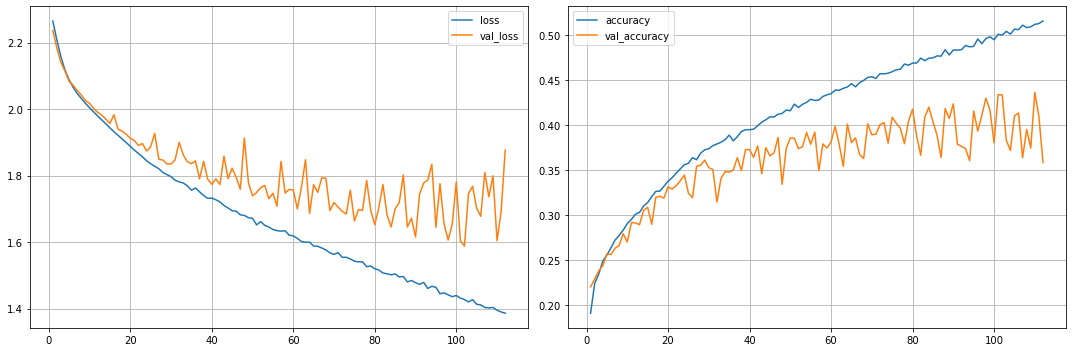

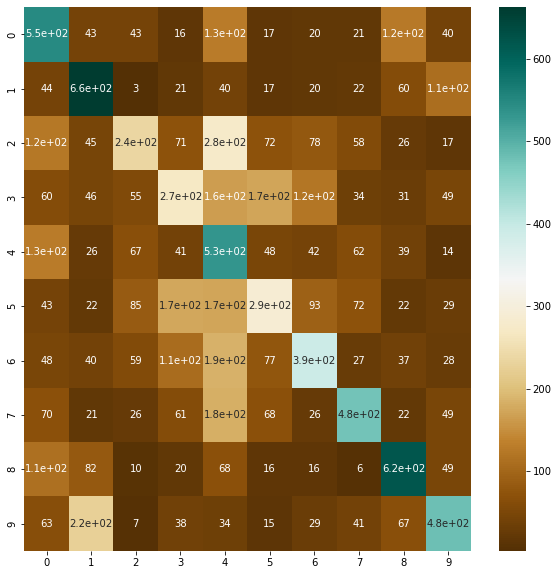

In [ ]:
mlp_relu = build_MLP('mlp_relu', activation = 'relu')
filepath = './model/'+ mlp_relu.name 
mlp_relu.summary()
mlp_relu = compiling(model=mlp_relu, optimizer='sgd')
if tf.io.gfile.exists(filepath):
  mlp_relu.load_weights(filepath)
else:
  callbacks_list = [EpochDots(report_every=10)]
  mlp_relu = fitting(model=mlp_relu, callbacks_list=callbacks_list, batch_size=256)
evaluation(model=mlp_relu)
plot_history()
heatmap_confusion_matrix(model=mlp_relu)

### Hyperbolic Tangent

مزایا:

این تابع صفرمحور است؛ بنابراین به مدل کمک می‌کند تا مقادیر ورودی منفی، خنثی و مثبت داشته باشد.
همچنین وزن ها نمیتوانند، مقادیر بسیار بزرگ منفی و مثبت به خود بگیرند و در نتیجه در دل خود یکجور منظم سازی هم دارد
تابع و مشتق آن هر دو یکنواخت هستند و همجا مشتق پذیر است

معایب:

محوشدگی گرادیان به این خاطر که اگر از مبدا کمی دور شویم مشتق آن به صفر میل میکند
هم‌گرایی کند به خاطر اینکه محاسبه مشتق آن ساده نیست 

Model: "mlp_tanH"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 3072)              0         
                                                                 
 dense_16 (Dense)            (None, 512)               1573376   
                                                                 
 activation_12 (Activation)  (None, 512)               0         
                                                                 
 dense_17 (Dense)            (None, 256)               131328    
                                                                 
 activation_13 (Activation)  (None, 256)               0         
                                                                 
 dense_18 (Dense)            (None, 128)               32896     
                                                                 
 activation_14 (Activation)  (None, 128)               0  

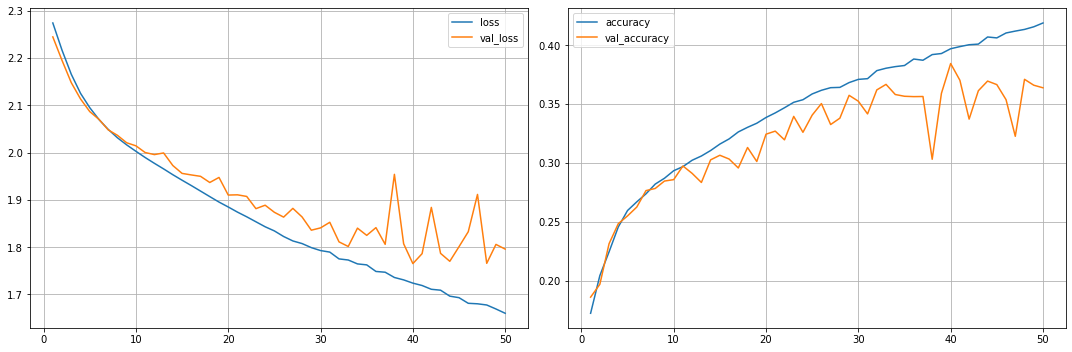

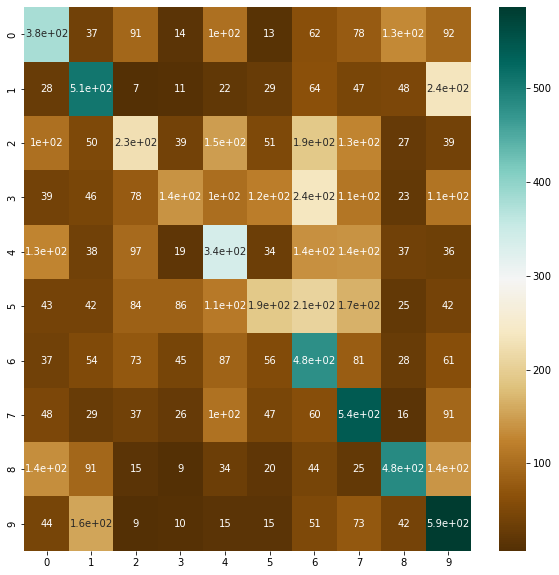

In [ ]:
mlp_tanH = build_MLP('mlp_tanH', activation = 'tanh')
filepath = './model/'+ mlp_tanH.name 
mlp_tanH.summary()

mlp_tanH = compiling(model=mlp_tanH, optimizer='sgd')
if tf.io.gfile.exists(filepath):
  mlp_tanH.load_weights(filepath)
else:
  callbacks_list = [EpochDots(report_every=10)]
  mlp_tanH = fitting(model=mlp_tanH, callbacks_list=callbacks_list, batch_size=256)
evaluation(model=mlp_tanH)
plot_history()
heatmap_confusion_matrix(model=mlp_tanH)

## ج

### crossentropy  vs  mean squared error 

در حل مسایل دسته بندی استفاده از خطای میانگین مربعات بهینه نمیباشد چراکه در این روش فاصله بین مقدار واقعی و مقدار پیشبینی شده را مد نظر قرار میدهد در صورتی که برای ما خطا صرفا اشتباه دسته بندی شدن است در صورتیکه برای ما زیان مثلا دو داده اشتباه دسته بندی شده یکسان است در صورتیکه این روش برای این دو زیان متفاوتی را در نظر میگیرد این خطا برای مسایل رگرسیون مناسب تر است تا مسایل دسته بندی

از نگاه دیگر خطا کراس آنتروپی به احتمال اشتباه دسته بندی شدن مینگرد و خب این بهتره دیگه!!!!!!

### ADAM
در این روش سعی میشود نرخ یادگیری به مرور زمان کاهش یابد.
حس میکنم به خاطر این گاهی ممکنه واگرا شه چون اگه الگوریتم در یک راه غلط قرار بگیره دیگه تو همون میمونه :((((((

Model: "crossentropy"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 3072)              0         
                                                                 
 dense_20 (Dense)            (None, 512)               1573376   
                                                                 
 activation_15 (Activation)  (None, 512)               0         
                                                                 
 dense_21 (Dense)            (None, 256)               131328    
                                                                 
 activation_16 (Activation)  (None, 256)               0         
                                                                 
 dense_22 (Dense)            (None, 128)               32896     
                                                                 
 activation_17 (Activation)  (None, 128)              

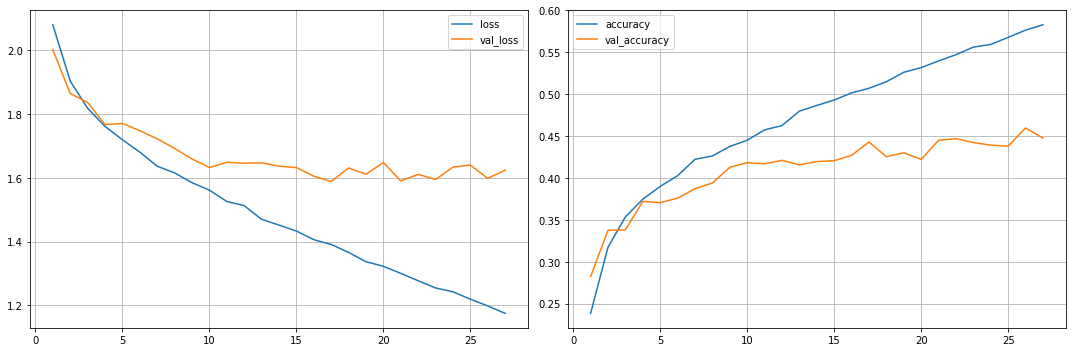

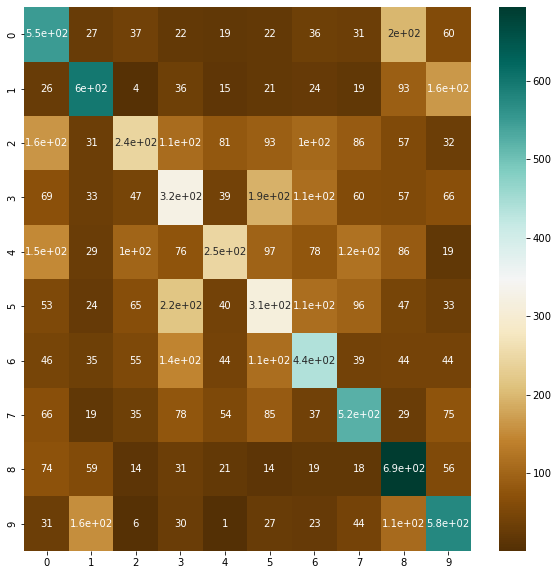

In [ ]:
crossentropy = build_MLP('crossentropy')
filepath = './model/'+ crossentropy.name 
crossentropy.summary()
crossentropy = compiling(model=crossentropy, optimizer='adam', loss='categorical_crossentropy')
if tf.io.gfile.exists(filepath):
  crossentropy.load_weights(filepath)
else:
  callbacks_list = [EpochDots(report_every=5)]
  crossentropy = fitting(model=crossentropy, batch_size=256, callbacks_list=callbacks_list)

evaluation(model=crossentropy)
plot_history()
heatmap_confusion_matrix(model=crossentropy)


Model: "mse"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 3072)              0         
                                                                 
 dense_24 (Dense)            (None, 512)               1573376   
                                                                 
 activation_18 (Activation)  (None, 512)               0         
                                                                 
 dense_25 (Dense)            (None, 256)               131328    
                                                                 
 activation_19 (Activation)  (None, 256)               0         
                                                                 
 dense_26 (Dense)            (None, 128)               32896     
                                                                 
 activation_20 (Activation)  (None, 128)               0       

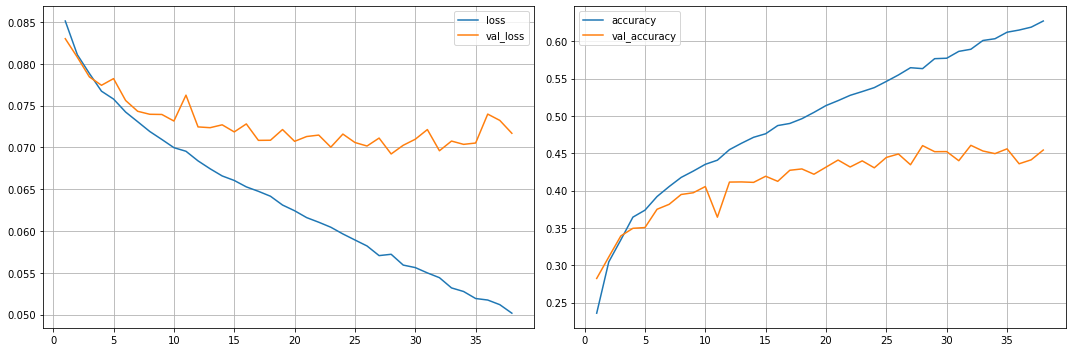

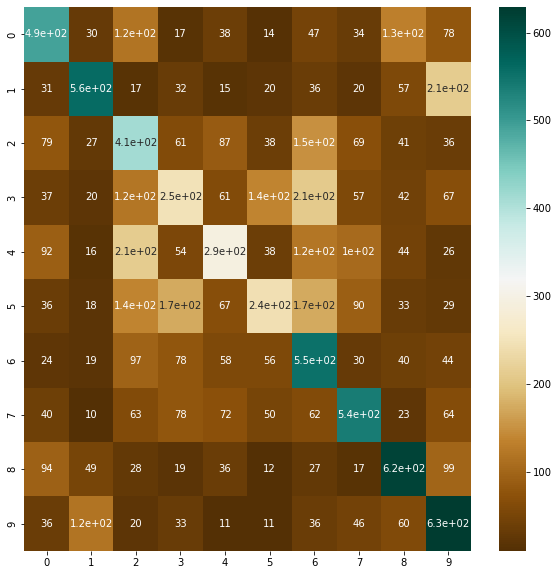

In [ ]:
mse = build_MLP('mse')
filepath = './model/'+ mse.name 
mse.summary()
mse = compiling(model=mse, optimizer='adam', loss='mean_squared_error')
if tf.io.gfile.exists(filepath):
  mse.load_weights(filepath)
else:
  callbacks_list = [EpochDots(report_every=5)]
  mse = fitting(model=mse, batch_size=256, callbacks_list=callbacks_list)
evaluation(model=mse)
plot_history()
heatmap_confusion_matrix(model=mse)


## ه


با توجه به خروجی زیر به نظر مدل با ویژگی های زیر بهتر باشه

crossentropy + SGD + relu

البته چون خود مدل مدل ضعیفی است خیلی به اینا اعتباری نیست بهتر بود این موضوع تو شبکه های کانولوشنی که قوی ترن بررسی میشد

In [ ]:
print('report crossentropy + SGD + relu:')
print(reporting(model=mlp256, X=X_test, y=y_test))
print('\n')
print('report crossentropy + adam + relu:')
print(reporting(model=crossentropy, X=X_test, y=y_test))
print('\n')
print('report mse + adam + relu:')
print(reporting(model=mse, X=X_test, y=y_test))
print('\n')
print('report crossentropy + adam + tanH :')
print(reporting(model=mlp_tanH, X=X_test, y=y_test))

report crossentropy + SGD + relu:
              precision    recall  f1-score   support

           0       0.44      0.54      0.49      1000
           1       0.52      0.66      0.58      1000
           2       0.32      0.41      0.36      1000
           3       0.38      0.17      0.23      1000
           4       0.39      0.31      0.35      1000
           5       0.40      0.23      0.29      1000
           6       0.39      0.50      0.44      1000
           7       0.49      0.53      0.51      1000
           8       0.66      0.53      0.58      1000
           9       0.49      0.58      0.53      1000

    accuracy                           0.45     10000
   macro avg       0.45      0.45      0.44     10000
weighted avg       0.45      0.45      0.44     10000



report crossentropy + adam + relu:
              precision    recall  f1-score   support

           0       0.45      0.55      0.49      1000
           1       0.59      0.60      0.60      1000
       

## و


میدانیم که تابع زیان به شکلی تنظیم شده است که زیان کل داده ها را کمینه کند بنابراین برایش کاهش زیان اکثریت داده ها مهم است که بتواند اکثریت داده ها را درست دسته بندی کند لذا برایش مهم نیست این داده ها از کدام دسته هستند بنابراین مدل کلاسی که داده های کمی دارد را خوب یاد نمیگیرد .
این اتفاق تعمیم پذیری مدل را کم کند

یک روش افزودن داده به داده های این کلاس برای متوازن کردن تعداد داده های هر دسته اس که مثلا با روش Data Augmentation
یا میتوانیم ضریب زیان داده های کلاسی که داده های کمی دارد را بیشتر در نظر بگیریم


## ز

In [ ]:
print('shape X:', X.shape)
print('shape y:', y.shape)

#delete half data of 2 classes
X_unbalanced, y_unbalanced = decrese_size_class(
    X,y,class_id=0, scale_size=2)
X_unbalanced, y_unbalanced = decrese_size_class(
    X_unbalanced,y_unbalanced,class_id=2, scale_size=2)
print('shape X unbalanced:', X_unbalanced.shape)
print('shape y unbalanced:', y_unbalanced.shape)

#add data to 2 classes
X_balanced, y_balanced = increase_size_class(
    X_unbalanced,y_unbalanced,class_id=0, scale_size=2)
X_balanced, y_balanced = increase_size_class(
    X_balanced,y_balanced,class_id=2, scale_size=2)
print('shape X_balanced:', X_balanced.shape)
print('shape y_balanced:', y_balanced.shape)

shape X: (50000, 32, 32, 3)
shape y: (50000, 10)
shape X unbalanced: (45000, 32, 32, 3)
shape y unbalanced: (45000, 10)
shape X_balanced: (50000, 32, 32, 3)
shape y_balanced: (50000, 10)


In [ ]:
#split data into training and validation sets 
X_train_balanced, X_valid_balanced, y_train_balanced, y_valid_balanced = split_normal(
    X=X_balanced, y=y_balanced, data_name='_balanced')

shape X_train_balanced : (40000, 32, 32, 3)
shape X_valid_balanced : (10000, 32, 32, 3)
shape X_test: (10000, 32, 32, 3)

shape y_train_balanced : (40000, 10)
shape y_valid_balanced : (10000, 10)
shape y_test: (10000, 10)


In [ ]:
mlp_augmented = build_MLP('mlp_augmented')
filepath = './model/'+ mlp_augmented.name 
mlp_augmented.summary()
mlp_augmented = compiling(model=mlp_augmented, optimizer='adam', loss='categorical_crossentropy')
if tf.io.gfile.exists(filepath):
  mlp_augmented.load_weights(filepath)
else:
  callbacks_list = [EpochDots(report_every=5)]
  mlp_augmented = fitting(model=mlp_augmented, batch_size=256,
                          callbacks_list=callbacks_list,
                          X_train=X_train_balanced, y_train=y_train_balanced,
                          validation_data=(X_valid_balanced, y_valid_balanced))
evaluation(model=mlp_augmented)

Model: "mlp_augmented"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 3072)              0         
                                                                 
 dense_28 (Dense)            (None, 512)               1573376   
                                                                 
 activation_21 (Activation)  (None, 512)               0         
                                                                 
 dense_29 (Dense)            (None, 256)               131328    
                                                                 
 activation_22 (Activation)  (None, 256)               0         
                                                                 
 dense_30 (Dense)            (None, 128)               32896     
                                                                 
 activation_23 (Activation)  (None, 128)             

# CNN

## الف

به وضوح دقت حدود 10-15 درصد نسبت به شبکه کاملا متصل افزایش یافته است

In [ ]:
cnn = build_CNN('cnn')
cnn = FC_net(cnn)
cnn.summary()
filepath = './model/'+ cnn.name 
cnn = compiling(model=cnn, optimizer='adam', loss='categorical_crossentropy')
if tf.io.gfile.exists(filepath):
  cnn.load_weights(filepath)
else:
  callbacks_list = [EpochDots(report_every=10)]
  cnn = fitting(model=cnn, batch_size=256, callbacks_list=callbacks_list)
evaluation(model=cnn)

Model: "cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_31 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 conv2d_32 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 conv2d_33 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 conv2d_34 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 conv2d_35 (Conv2D)          (None, 32, 32, 128)       147584    
                                                                 
 flatten_5 (Flatten)         (None, 131072)            0       

## ب

### batch_normalization

هرچقدر لایه ها بیشتر باشن دو مساله خودشو نشون میده کاهش قدرت گرایان و تغییر بیش از پیش در توزیع داده ورودی
این لایه میاد این دوتا مساله رو برطرف میکنه.

این لایه برای نرمال سازی داده ها در داخل شبکه انجام میشه . زمانی که محاسبات مختلف روی داده ورودی اعمال میشه توزیع اون هم دستخوش تغییر میشه. با بچ نرمالیزیشن خروجی لایه قبل با یک میانگین و واریانس که شبکه یادشون میگیره نرمال میشن 

گردایان دیسنت خیلی سریعتر میتونه پیش بره و حرکت زیگزاکی کمتری خواهد داشت 

علاوه بر این قضیه در توابع اشباع شونده هم این موضوع باعث میشه تا دیرتر این نوع توابع در نواحی اشباع شدگی قرار بگیرن و در نتیجه فرایند آموزش دیرتر دست به گریبان مشکلاتی مثل اشباع گرادیان بشن و گرادیان ها مقادیر متناسب تری برای مدت زمان بیشتری داشته باشن.



### Pooling

و در واقع هدف اصلیش (کوچک کردن) تصویر ورودی به منظور کاهش بارمحاسباتی، حافظه و تعداد پارامترها , است.

کاهش اندازه تصویر ورودی همچنین باعث میشه که شبکه عصبی حساسیتش نسبت به جابجایی تصویر(مستقل از موقعیت) کم بشه.

درست مثل لایه کانولوشن هرنرون در لایه پولینگ  به خروجی تعداد محدودی از نرون ها در لایه قبلی متصل هستش در واقع  این نرون ها داخل یک مستطیلی شکل کوچک قرار گرفته اند.

برای لایه پولینگ شما چند تا مورد را باید مشخص کنید از جمله اندازه ، استرید و نوع پدینگی که مد نظر دارید.اینو در نظر داشته باشید که نرون های لایه پولینگ وزن ندارند در واقع آنها عملیات تجمیع را با استفاده از یک تابع تجمیع همانند ماکزیمم و میانگین را انجام می دهند.

به وضوح دقت حدود 10-15 درصد نسبت به شبکه کاملا متصل افزایش یافته است همچنین سرعت همگرایی نیز افزایش یافته است

In [ ]:
cnn_batch_pool = build_CNN(name='cnn_batch_pool', has_batchNormalization=True, has_pooling=True)
cnn_batch_pool = FC_net(cnn_batch_pool)
cnn_batch_pool.summary()
filepath = './model/'+ cnn_batch_pool.name 
cnn_batch_pool = compiling(model=cnn_batch_pool, optimizer='adam', loss='categorical_crossentropy')
if tf.io.gfile.exists(filepath):
  cnn_batch_pool.load_weights(filepath)
else:
  callbacks_list = [EpochDots(report_every=2)]
  cnn_batch_pool = fitting(model=cnn_batch_pool, batch_size=256, callbacks_list=callbacks_list)
evaluation(model=cnn_batch_pool)

Model: "cnn_batch_pool"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                    

## ج

### Dropout

در یادگیری ماشین، یکی از راه‌های جلوگیری از بیش برازش رگولاریزاسیون است. رگولاریزاسیون با اضافه کردن یک پنالتی به تابع هزینه، بیش برازش را کاهش می‌دهد. با اضافه کردن این پنالتی، مدل به گونه‌ای آموزش داده می‌شود که وزن‌های ویژگی‌های وابسته، آپدیت نمی‌شوند. این حرکت یک رویکرد برای رگولاریزاسیون در شبکه‌های عصبی است که باعث کاهش یادگیری‌های تکراری میان نورون‌ها می‌شود. 
این حرکت خطای تعمیم‌پذیری را با کاهش گنجایش مدل کمتر می‌کند؛ بدین ترتیب که در هر دور آموزشی، به جای استفاده از همه‌ نورون‌ها، تنها برخی از نورون‌ها (با یک احتمال ) فعال می‌شوند. 

به بیان ریاضیاتی تر یک روش برای کاهش خطای تعمیم پذیری، ترکیب چندین مدل مختلف است هر مدلی ممکن است در یک قسمت از داده‌های آموزشی خود مشکل یا خطایی داشته باشد که با خطای مدل‌های دیگر متفاوت است. منطق تکنیک مدل‌های گروهی این است که با ترکیب چند مدل می‌توان مدلی مقاوم‌تر به دست آورد؛ چون قسمت‌هایی که در بیشتر مدل‌ها درست بوده‌اند تغییر نخواهند کرد و خطا کاهش خواهد یافت. بدین ترتیب، مدل‌ میانگین عملکردی حداقل برابر با مدل‌های تشکیل‌دهنده خواهد داشت. 

در واقع میدانیم با میانگین گیری به شکل قابل توجهی میتوان واریانس را کاهش داد و کاهش واریانس باعث کاهش خطای تعمیم پذیری میشود

با این حال، آموزش تعداد زیادی مدل، به خصوص شبکه های عصبی عمیق، از نظر محاسباتی هزینه‌بر است. این مشکل فقط مختص مرحله‌ آموزش نیست، بلکه افزایش تعداد مدل‌ها در مرحله‌ استنتاج نیز منجر به افزایش هزینه‌ محاسبات می‌شود. بنابراین، میانگین‌گیری از تعداد زیادی شبکه‌ عصبی عمیق، به خصوص وقتی منابع محدود باشند، غیرکاربردی خواهد بود لذا این حرکت یه جورایی این خواسته ما رو برآورده میکنه 

In [ ]:
cnn_dropout= build_CNN(name='cnn_dropout', has_batchNormalization=True, has_pooling=True,
                       has_dropout=True, dropout_rate=0.2)
cnn_dropout = FC_net(cnn_dropout, has_dropout=True, dropout_rate=0.5)
cnn_dropout.summary()
filepath = './model/'+ cnn_dropout.name 
cnn_dropout = compiling(model=cnn_dropout, optimizer='adam', loss='categorical_crossentropy')
if tf.io.gfile.exists(filepath):
  cnn_dropout.load_weights(filepath)
else:
  callbacks_list = [EpochDots(report_every=2)]
  cnn_dropout = fitting(model=cnn_dropout, batch_size=256, callbacks_list=callbacks_list)
evaluation(model=cnn_dropout)
# plotting(model=cnn_dropout)

Model: "cnn_dropout"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_7 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                       

# Data Augmentation

## الف

### مزایا و نحوه عملکرد
زمانی که شما یک مدل یادگیری ماشین را 
آموزش می دهید، در حقیقت، پارامتر های آن را بگونه ای تنظیم می کنید که بتواند یک ورودی خاص (مانند تصویر) را به خروجی (یک برچسب) نگاشت دهد.
 هدف از بهینه سازی ما، پیدا کردن آن نقطه مطلوبی است که اشتباهات مدل ما در آنجا کم باشد و این موضوع زمانی رخ می دهد که پارامتر های مدل به درستی تنظیم شده باشند. 
 
**جبران کمبود داده**

 شبکه های عصبی جدید و مدرن معمولاً دارای چندین میلیون پارامتر هستند. طبیعتا اگرشما پارامتر های بسیار زیادی داشته باشید، لازم است تعداد مناسبی از مثال ها را به مدل خود نشان دهید تا عملکرد خوبی را بدست آورید. همچنین، تعداد پارامترهایی که نیاز دارید، متناسب با پیچیدگی وظیفه ای است که مدل شما انجام می دهد.

حال اگر داده زیادی نداشته باشم لازم نیست به دنبال داده های جدیدی باشیم تا پایگاه داده خود اضافه کنیم. زیرا شبکه ها ی عصبی در ابتدا هوشمند نیستند. برای مثال، یک شبکه عصبی با آموزش ضعیف، تصور می کند 10 تصویر مصنوعی نشان داده در زیر، مجزا و بصورت تصاویر منحصربفردی هستند.
یک شبکه عصبی کانولوشنی که می تواند اشیا را حتی اگر در جهات مختلف قرار گیرند، بصورت مقاوم کلاس بندی کند، دارای ویژگی تغییرناپذیری خواهد بود. بطور خاص، یک شبکه کانولوشن می تواند نسبت به جابجایی، نقطه دید، اندازه و یا شدت روشنایی (یا ترکیبی از این ها) تغییرناپذیر باشد.

این موضوع، اساساً فرضیه داده افزایی است. در دنیای واقعی، ممکن است پایگاه داده ای داشته باشیم که تصاویر آن در شرایط محدودی تهیه شده باشد. اما برنامه هدف ما ممکن است در شرایط مختلفی مانند جهت، موقعیت، مقیاس، روشنایی و غیره وجود داشته باشد. این موقعیت ها ، توسط آموزش شبکه عصبی با داده ها ی اصلاح شده مصنوعی اضافی در نظر گرفته می شوند.

**جلوگیری از بیش برازش**

شبکه عصبی شما، به همان خوبی داده هایی است که به آن می دهید. حال چگونه می توان از این رویداد جلوگیری نمود؟ ما باید مقدار ویژگی های نامربوط در پایگاه داده را کاهش دهیم. مثلا برای مساله دسته بندی یک راه حل ساده، اضافه نمودن تصاویری از تصاویر موجود در پایگاه داده را بصورت افقی بچرخانید، بگونه ای که تصویر آن شی در جهت مخالف قرار گیرد.
با انجام این عملیات افزایش داده، می توان از یادگیری ویژگی ها ی نامرتبط، توسط شبکه خود جلوگیری نموده و اساساً عملکرد کلی را بهبود بخشید.


### انواع روش ها

**(Flip) قرینه سازی**

می توان تصاویر را بصورت افقی و عمودی قرینه نمود. برخی از چارچوب ها ، تابعی برای قرینه سازی عمودی ندارند. اما می توان گفت قرینه عمودی، همان چرخش یک تصویر با زاویه ۱۸۰ درجه و سپس انجام یک قرینه افقی است.

**(Rotation) چرخش**

**(Scale) مقیاس**

تصویر می تواند بصورت درونی و یا بیرونی، مقیاس بندی شود. اگر بصورت بیرونی مقیاس شود، اندازه نهایی تصویر بزرگ تر از اندازه تصویر اولیه است. عمده چارچوب های تصویر، بخشی از تصویر جدید را با اندازه ای برابر با تصویر اولیه برش می دهند.

**(Crop) برش**

برخلاف مقیاس بندی، شما تنها از بخشی از تصویر اولیه بصورت تصادفی نمونه برداری می کنید. سپس اندازه این بخش را به اندازه تصویر اولیه تغییر می دهید. این روش معمولاً تحت عنوان برش تصادفی خوانده می شود.

**(Translation) جابجایی**

این عملیات، شامل حرکت تصویر در امتداد راستای دو محور مختصات و یا هر دو راستا است. این روش برای داده افزایی بسیار مفید است، چرا که اکثر اشیای موجود در تصاویر می توانند تقریباً در هرجایی از تصویر قرار گیرند. این موضوع، شبکه عصبی کانولوشنی شما را مجبور می کند که به همه جا نگاه کند.

**(Gaussian Noise) نویز گوسی**

بیش برازش زمانی رخ می دهد که شبکه عصبی شما سعی به یادگیری ویژگی های فرکانس بالایی ( الگوهایی که به دفعات زیاد رخ می دهند ) دارد که ممکن است مفید نیز نباشند. نویز گوسی ، که دارای میانگین صفر است، دارای اطلاعاتی در تمام فرکانس ها می باشد و بدین ترتیب بصورت مؤثر، ویژگی ها ی فرکانس بالا را دچار اعوجاج می کند. همچنان مؤلفه ها ی فرکانسی پایین تر ( معمولاً داده های مورد نظر شما ) نیز ممکن است دچار اعوجاج شوند، اما شبکه عصبی شما یاد می گیرد که آن را نادیده بگیرد. اضافه نمودن تنها مقدار کمی نویز، می تواند قابلیت یادگیری را افزایش دهد.
حالتی ضعیف از این نویز، نویز نمک و فلفل است که بصورت پیکسل های سفید و سیاه بصورت پراکنده در کل تصویر نمایش داده می شود. این نویز تأثیری مشابه با اضافه نمودن نویز گوسی دارد، اما سطح اعوجاج اطلاعاتی کمتری دارد.


## ب

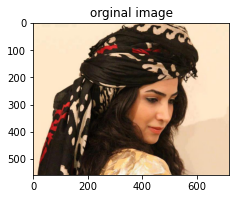

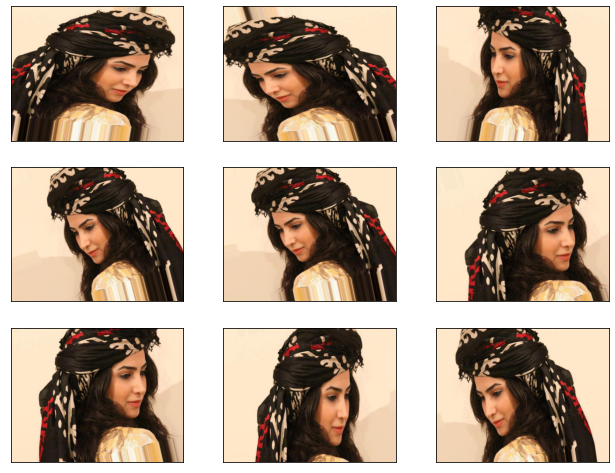

In [ ]:
import urllib.request
from PIL import Image
url = 'https://upload.wikimedia.org/wikipedia/commons/f/f9/%D8%B2%D9%86_%D9%84%D8%B1_%D8%A8%D8%A7_%DA%AF%D9%84%D9%88%D9%86%DB%8C.jpg'
urllib.request.urlretrieve(url,'my_img.jpg')
img = Image.open("my_img.jpg")

pix = np.array(img)
img_test = pix.astype('float32')
img_test/=255
plt.figure(figsize=(7.2/2,5.59/2))
plt.imshow(img_test)
plt.title('orginal image')
plt.show()
print()
img_test = np.expand_dims(img_test,axis=0)
imGen = datagen.flow(img_test)
array_img_x =[]
# fig = plt.figure(figsize=(5*7.2/2,2*5.59/2))
fig = plt.figure(figsize=(3*7.2/2,3*5.59/2))
for i in range(9):
  ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
  batch = imGen.next()
  ax.imshow(batch[0])

## ج د

In [ ]:
print('shape X :', X.shape)
# y_oneHot = keras.utils.to_categorical(y, num_classes)
print('shape y :', y.shape)
X_unbalanced, y_unbalanced = decrese_size_class(X,y, class_id=3, scale_size=10)
X_unbalanced, y_unbalanced = decrese_size_class(X_unbalanced,y_unbalanced,
                                                            class_id=5, scale_size=10)
print('shape X_unbalanced :', X_unbalanced.shape)
print('shape y_unbalanced :', y_unbalanced.shape)

X_balanced, y_balanced = increase_size_class(
    X_unbalanced,y_unbalanced,class_id=3, scale_size=10)
X_balanced, y_balanced = increase_size_class(
    X_balanced,y_balanced,class_id=5, scale_size=10)
print('shape X_balanced:', X_balanced.shape)
print('shape y_balanced:', y_balanced.shape)

shape X : (50000, 32, 32, 3)
shape y : (50000, 10)
shape X_unbalanced : (41000, 32, 32, 3)
shape y_unbalanced : (41000, 10)
shape X_balanced: (50000, 32, 32, 3)
shape y_balanced: (50000, 10)


In [ ]:
X_train_unbalanced, X_valid_unbalanced, y_train_unbalanced, y_valid_unbalanced = split_normal(
    X=X_unbalanced, y=y_unbalanced, data_name='_unbalanced')


shape X_train_unbalanced : (32800, 32, 32, 3)
shape X_valid_unbalanced : (8200, 32, 32, 3)
shape X_test: (10000, 32, 32, 3)

shape y_train_unbalanced : (32800, 10)
shape y_valid_unbalanced : (8200, 10)
shape y_test: (10000, 10)


In [ ]:
#split balanced data into training and validation sets 
X_train_balanced, X_valid_balanced, y_train_balanced, y_valid_balanced = split_normal(
    X=X_balanced, y=y_balanced, data_name='_balanced')

shape X_train_balanced : (40000, 32, 32, 3)
shape X_valid_balanced : (10000, 32, 32, 3)
shape X_test: (10000, 32, 32, 3)

shape y_train_balanced : (40000, 10)
shape y_valid_balanced : (10000, 10)
shape y_test: (10000, 10)


In [ ]:
cnn_unbalanced= build_CNN(name='cnn_unbalanced',
                          has_batchNormalization=True, has_pooling=True,
                          has_dropout=True, dropout_rate=0.2)
cnn_unbalanced = FC_net(cnn_unbalanced, has_dropout=True, dropout_rate=0.5)
cnn_unbalanced.summary()
filepath = './model/'+ cnn_unbalanced.name 
cnn_unbalanced = compiling(model=cnn_unbalanced, optimizer='adam', loss='categorical_crossentropy')

if tf.io.gfile.exists(filepath):
  cnn_unbalanced.load_weights(filepath)
else:
  callbacks_list = [EpochDots(report_every=2)]
  cnn_unbalanced = fitting(model=cnn_unbalanced,
                           batch_size=256, callbacks_list=callbacks_list,
                           X_train=X_train_unbalanced, y_train=y_train_unbalanced,
                           validation_data=(X_valid_unbalanced, y_valid_unbalanced))
evaluation(model=cnn_unbalanced,
           X_train=X_train_unbalanced, y_train=y_train_unbalanced,
           X_valid=X_valid_unbalanced, y_valid=y_valid_unbalanced)

Model: "cnn_unbalanced"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_12 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_19 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_13 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                    

In [ ]:
cnn_balanced= build_CNN(name='cnn_balanced',
                          has_batchNormalization=True, has_pooling=True,
                          has_dropout=True, dropout_rate=0.2)
cnn_balanced = FC_net(cnn_balanced, has_dropout=True, dropout_rate=0.5)
cnn_balanced.summary()
filepath = './model/'+ cnn_balanced.name 
cnn_balanced = compiling(model=cnn_balanced, optimizer='adam', loss='categorical_crossentropy')

if tf.io.gfile.exists(filepath):
  cnn_balanced.load_weights(filepath)
else:
  callbacks_list = [EpochDots(report_every=2)]
  cnn_balanced = fitting(model=cnn_balanced,
                           batch_size=256, callbacks_list=callbacks_list,
                           X_train=X_train_balanced, y_train=y_train_balanced,
                           validation_data=(X_valid_balanced, y_valid_balanced))
evaluation(model=cnn_balanced,
           X_train=X_train_balanced, y_train=y_train_balanced,
           X_valid=X_valid_balanced, y_valid=y_valid_balanced)

Model: "cnn_balanced"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_18 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_25 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_19 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                      

without decrese data :




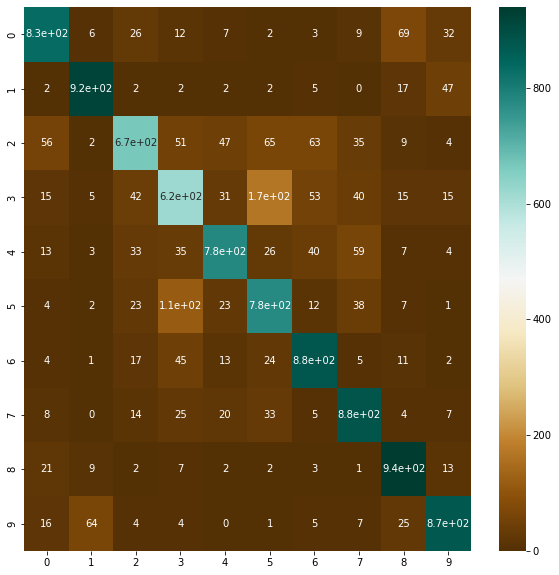









              precision    recall  f1-score   support

           0       0.86      0.83      0.85      1000
           1       0.91      0.92      0.92      1000
           2       0.80      0.67      0.73      1000
           3       0.68      0.62      0.65      1000
           4       0.84      0.78      0.81      1000
           5       0.71      0.78      0.74      1000
           6       0.82      0.88      0.85      1000
           7       0.82      0.88      0.85      1000
           8       0.85      0.94      0.89      1000
           9       0.87      0.87      0.87      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



In [ ]:
print('without decrese data :',end='\n\n\n')
heatmap_confusion_matrix(model=cnn_dropout)
print('\n\n\n')
print(reporting(model=cnn_dropout, X=X_test, y=y_test))



with unbalnced data




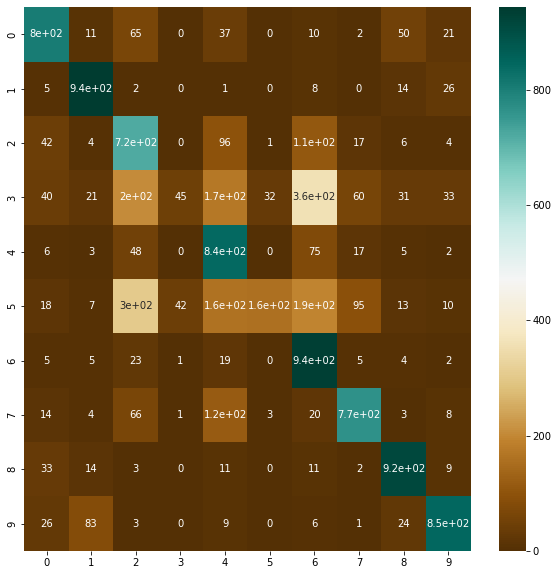









              precision    recall  f1-score   support

           0       0.81      0.80      0.81      1000
           1       0.86      0.94      0.90      1000
           2       0.50      0.72      0.59      1000
           3       0.51      0.04      0.08      1000
           4       0.58      0.84      0.68      1000
           5       0.81      0.16      0.26      1000
           6       0.54      0.94      0.69      1000
           7       0.79      0.77      0.78      1000
           8       0.86      0.92      0.89      1000
           9       0.88      0.85      0.86      1000

    accuracy                           0.70     10000
   macro avg       0.71      0.70      0.65     10000
weighted avg       0.71      0.70      0.65     10000



In [ ]:
print('\nwith unbalnced data',end='\n\n\n')
heatmap_confusion_matrix(model=cnn_unbalanced)
print('\n\n\n')
print(reporting(model=cnn_unbalanced, X=X_test, y=y_test))


with balnced data




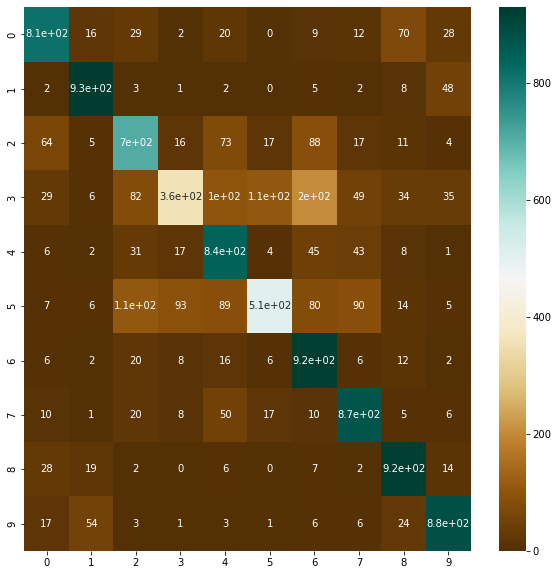









              precision    recall  f1-score   support

           0       0.83      0.81      0.82      1000
           1       0.89      0.93      0.91      1000
           2       0.70      0.70      0.70      1000
           3       0.71      0.36      0.48      1000
           4       0.70      0.84      0.77      1000
           5       0.77      0.51      0.61      1000
           6       0.67      0.92      0.78      1000
           7       0.79      0.87      0.83      1000
           8       0.83      0.92      0.87      1000
           9       0.86      0.89      0.87      1000

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.76     10000
weighted avg       0.78      0.78      0.76     10000



In [ ]:
print('with balnced data',end='\n\n\n')
heatmap_confusion_matrix(model=cnn_balanced)
print('\n\n\n')
print(reporting(model=cnn_balanced, X=X_test, y=y_test))

### تحلیل ماتریس های آشفتگی و معیار های دقت

مقایسه ماتریس آشفتگی و معیار های دقت در حالت عادی و حالتی که داده های کلاس های سه و پنج را کاهش داده ایم:
 در سطر سوم (پنجم) مقدار خانه سوم (پنجم) نسبت بقیه خانه های در این سطر کاهش محسوسی داشته است که نشان دهنده افت دقت در این دو کلاس است علاوه بر آن دقت کلی مدل و معیار اف1 برای این دو کلاس کاهش زیادی داشته است که مشخص است به علت کمبود داده مدل این دو کلاس را خوب یاد نگرفته است.




مقایسه ماتریس آشفتگی و معیارهای دقت در حالتی که کمبود داده داریم و حالتی که دادهای مصنوعی برای یادگیری بهتر اضافه کرده ایم:
خب بازم همون چیزایی که تو پاراگراف بالا گفتم رو اگه مقایسه کنیم میبینیم وضع بهتر شده دیگه 

